<a href="https://colab.research.google.com/github/aman190202/AutoEncoders/blob/main/ImageColorization_attempt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries Imported

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import PIL
import os
import os.path
from PIL import Image

In [2]:
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip /content/val2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/00000011

Data Creation and Manipulation

In [3]:
from PIL import Image
import os

directory = '/content/val2017'
directory_intended= '/content/val2017_grey'
os.mkdir(directory_intended)
def convtogrey(directory,filename):
    fn = os.path.join(directory, filename)
    img = Image.open(fn)
    imgGray = img.convert('L')
    filename= os.path.join(directory_intended,filename)
    imgGray.save(filename)

for filename in os.listdir(directory):
    if filename == '.DS_Store' :
        continue
    convtogrey(directory,filename)

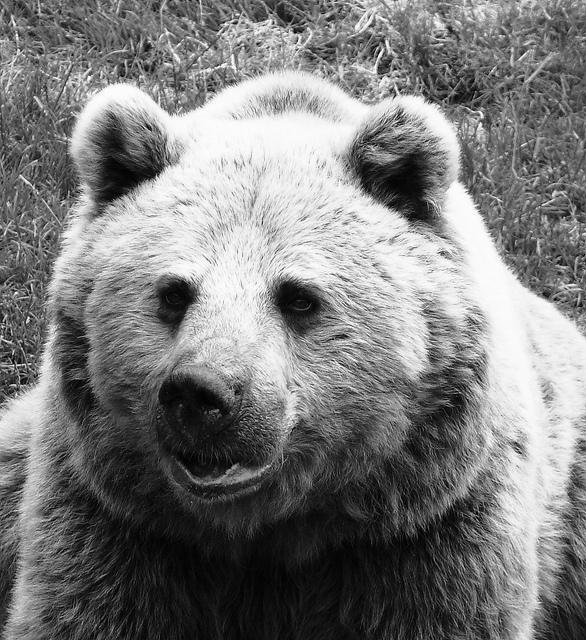

In [4]:
from IPython.display import Image
Image('/content/val2017_grey/000000000285.jpg')

In [5]:
SIZE = 160
color_img = []
for filename in os.listdir(directory):    
      img = cv2.imread(directory + '/'+filename,1)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (SIZE, SIZE))
      img = img.astype('float32') / 255.0
      color_img.append(img_to_array(img))


gray_img = []
for filename in os.listdir(directory_intended):
      img = cv2.imread(directory_intended + '/'+filename,1)
      img = cv2.resize(img, (SIZE, SIZE))
      img = img.astype('float32') / 255.0
      gray_img.append(img_to_array(img))

In [6]:
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

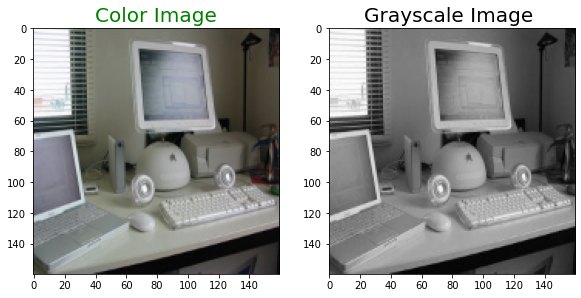

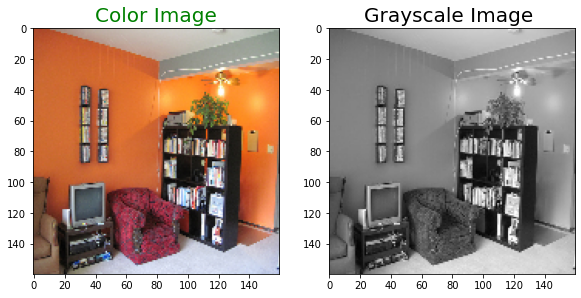

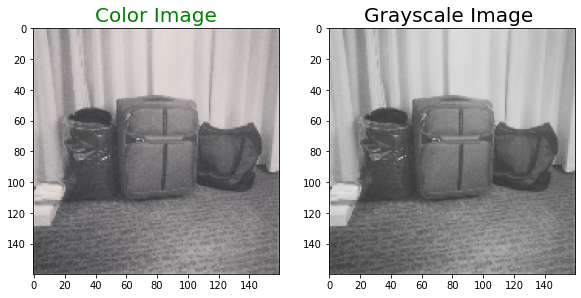

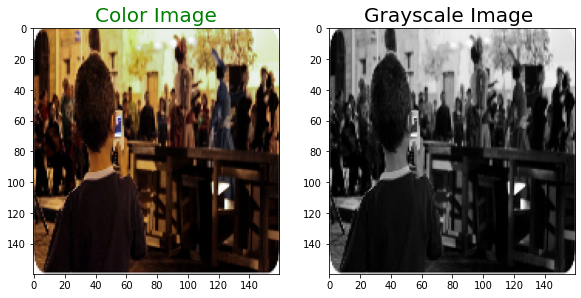

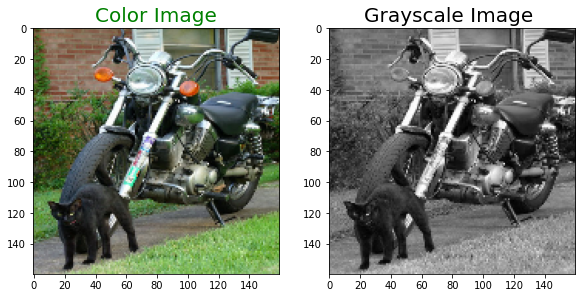

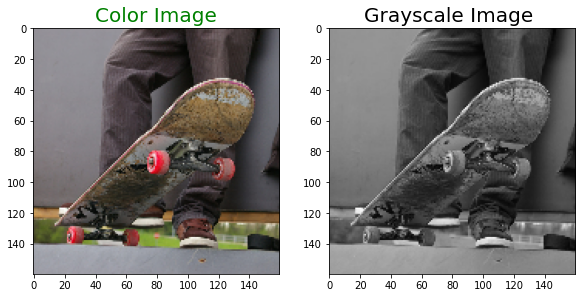

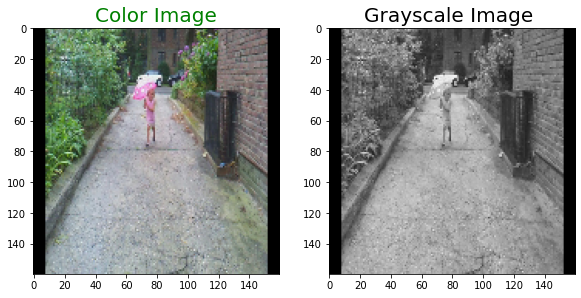

In [7]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

In [ ]:
train_gray_image = gray_img[:3000]
train_color_image = color_img[:3000]

test_gray_image = gray_img[3000:]
test_color_image = color_img[3000:]
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

In [9]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [10]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [11]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 80, 80, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 40, 40, 128)  147584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 20, 20, 256)  296192      ['sequential_1[0][0]']       

In [12]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_g, train_c, epochs = 20,batch_size = 50,verbose = 1)

Epoch 1/20
100/100 [==============================] - 41s 231ms/step - loss: 0.2185 - acc: 0.3779
Epoch 2/20
100/100 [==============================] - 24s 237ms/step - loss: 0.0808 - acc: 0.4061
Epoch 3/20
100/100 [==============================] - 24s 243ms/step - loss: 0.0708 - acc: 0.4219
Epoch 4/20
100/100 [==============================] - 25s 248ms/step - loss: 0.0659 - acc: 0.4315
Epoch 5/20
100/100 [==============================] - 25s 254ms/step - loss: 0.0625 - acc: 0.4471
Epoch 6/20
100/100 [==============================] - 25s 246ms/step - loss: 0.0602 - acc: 0.4556
Epoch 7/20
100/100 [==============================] - 25s 246ms/step - loss: 0.0586 - acc: 0.4667
Epoch 8/20
100/100 [==============================] - 25s 249ms/step - loss: 0.0574 - acc: 0.4772
Epoch 9/20
100/100 [==============================] - 25s 248ms/step - loss: 0.0565 - acc: 0.4811
Epoch 10/20
100/100 [==============================] - 25s 248ms/step - loss: 0.0558 - acc: 0.4819
Epoch 11/20
100/100

In [13]:
model.evaluate(test_gray_image,test_color_image)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:923: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: ignored

In [17]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

predicted = np.clip(model.predict(test_gray_image[0].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
plot_images(test_color_image[0],test_gray_image[i],predicted)


IndexError: ignored